In [2]:
import os#
os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
#os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#

import pandas as pd
import torch


import numpy as np
from stk_search.utils.config_utils import read_config, save_config
from stk_search.utils import update_datasets
import importlib
importlib.reload(update_datasets)
os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [3]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
case_name = 'BO_precursor'#'BO_learned'
df_total_path = "data/output/Full_dataset/New_target200324.csv"
df_precursors_path ="data/output/Prescursor_data/precursor_data_200324.pkl"
exp_name = "new_target"
search_space_loc = "data/input/search_space/test/search_space1.pkl"
which_acquisition = "EI"

string_to_run_notbook, script_qsub = run_hpc_utils.generate_string_run(
                case=case_name,
                target="target",
                aim='maximise',
                num_elem_initialisation=50,
                num_iteration=20,
                df_path=df_total_path,
                benchmark=True,
                test_name= exp_name,
                df_precursors_path=df_precursors_path,
                frag_properties="selected",
                search_space_loc = search_space_loc,
                which_acquisition = which_acquisition,
            )

%run $string_to_run_notbook

src/dev_scripts/run_search_new.py  --case BO_precursor --test_name new_target --target target --aim maximise --benchmark 1 --num_iteration 20 --num_elem_initialisation 50 --which_acquisition EI --df_path data/output/Full_dataset/New_target200324.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --config_dir /rds/general/user/ma11115/home/Geom3D/Geom3D/training/SchNet_frag/ --search_space_loc data/input/search_space/test/search_space1.pkl --frag_properties selected --lim_counter 10


 number of fragment 6
True benchmark


C:\Users\ma11115\OneDrive - Imperial College London\github_folder\STK_search\src\dev_scripts\run_search_new.py:50: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


BO_precursor   case  
Index(['Atom_num', 'HOMO (eV)', 'LUMO (eV)', 'HOMO_LUMO_GAP (eV)', 'IP (eV)',
       'EA (eV)', '1 Excited state Energy (eV)', '1 Excited state Osc',
       '2 Excited state Energy (eV)', '2 Excited state Osc',
       '3 Excited state Energy (eV)', '3 Excited state Osc'],
      dtype='object')
Inputs saved.
element Inchikey suggested: MFUVXZZZMSZXEY-UHFFFAOYSA-N, Eval: -2.9501651529995465
element Inchikey suggested: GTPAHTCQACDFGB-UHFFFAOYSA-N, Eval: -3.41699413473523
element Inchikey suggested: JCJHXZKXQMVHJJ-UHFFFAOYSA-N, Eval: -0.8827270869203682
element Inchikey suggested: RMCFTXPLRLABSB-WXCCCHMESA-N, Eval: -3.0993161432802645
element Inchikey suggested: IPZQUFFQXVAVJY-ZJPIGYMHSA-N, Eval: -2.0648573611547767
element Inchikey suggested: DPQXRHMIAQKCEY-OBCHNMDOSA-N, Eval: -1.28941209240695
element Inchikey suggested: GSSVJXMUXQPVPG-UHFFFAOYSA-N, Eval: -1.7357326421515415
element Inchikey suggested: ROFUETVPHNLZMD-MIXAMLLLSA-N, Eval: -2.579629300843631
element In

KeyboardInterrupt: 

# load results and plot some metrics

In [ ]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"data/output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        list_json.append(json.load(f))
    f.close()
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
#df = df[~df['benchmark']]
print(df.shape)
df_all = df.copy()
df_all.head()


(4, 21)


,num_iteration,num_elem_initialisation,test_name,case,target_name,config_dir,aim,which_acquisition,lim_counter,search_space_loc,...,df_path,df_precursors_path,benchmark,dataset_representation_path,frag_properties,run_search_name,search_output_folder,date,git_version,search_exp_file
0,2,50,new_target,BO_precursor,target,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,maximise,EI,10,data/input/search_space/test/search_space1.pkl,...,data/output/Full_dataset/New_target200324.csv,data/output/Prescursor_data/precursor_data_200...,True,,selected,222d50010d094d43ab46d4d924b8b123,data/output/search_experiment/6_frag/new_target,20240508,6d21a772729c1bad1e9b27f2e0d422f138d8cfe0,data/output/search_experiment/6_frag/new_targe...
1,20,50,new_target,BO_precursor,target,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,maximise,EI,10,data/input/search_space/test/search_space1.pkl,...,data/output/Full_dataset/New_target200324.csv,data/output/Prescursor_data/precursor_data_200...,True,,selected,31d13f32b74e48f1b5bae8cfba5aff87,data/output/search_experiment/6_frag/new_target,20240508,6d21a772729c1bad1e9b27f2e0d422f138d8cfe0,data/output/search_experiment/6_frag/new_targe...
2,2,50,new_target,BO_precursor,target,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,maximise,EI,10,data/input/search_space/test/search_space1.pkl,...,data/output/Full_dataset/New_target200324.csv,data/output/Prescursor_data/precursor_data_200...,True,,selected,4116f84d674344e0803806b150ce9ff9,data/output/search_experiment/6_frag/new_target,20240507,fdfbf2b6fbbf22024418dba45a362301e0ff0932,data/output/search_experiment/6_frag/new_targe...
3,2,50,new_target,BO_precursor,target,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,maximise,EI,10,data/input/search_space/test/search_space1.pkl,...,data/output/Full_dataset/New_target200324.csv,data/output/Prescursor_data/precursor_data_200...,True,,selected,d231d5997ccc47d28d5c8be77bb3b984,data/output/search_experiment/6_frag/new_target,20240507,fdfbf2b6fbbf22024418dba45a362301e0ff0932,data/output/search_experiment/6_frag/new_targe...


In [ ]:
num_iteration = 20
num_elem_initialisation = 50
oligomer_size = 6 
df_filtered = df_all[df_all['num_iteration']==num_iteration]
df_filtered = df_filtered[df_filtered['num_elem_initialisation']==num_elem_initialisation]
df_filtered = df_filtered[df_filtered['oligomer_size']==oligomer_size]
print(df_filtered.shape)
df_list = df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir'])
print(len(df_list))
df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir']).describe()

(1, 21)
1


num_iteration  \
                                                                                                          count   
case         frag_properties which_acquisition config_dir                                                         
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...           1.0   

                                                                                                         \
                                                                                                   mean   
case         frag_properties which_acquisition config_dir                                                 
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...  20.0   

                                                                                                       \
                                                                                                  std   
case         frag_properties which_acquisition config_dir                                               
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr... NaN   

                                                                                                         \
                                                                                                    min   
case         frag_properties which_acquisition config_dir                                                 
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...  20.0   

                                                                                                         \
                                                                                                    25%   
case         frag_properties which_acquisition config_dir                                                 
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...  20.0   

                                                                                                         \
                                                                                                    50%   
case         frag_properties which_acquisition config_dir                                                 
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...  20.0   

                                                                                                         \
                                                                                                    75%   
case         frag_properties which_acquisition config_dir                                                 
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...  20.0   

                                                                                                         \
                                                                                                    max   
case         frag_properties which_acquisition config_dir                                                 
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...  20.0   

                                                                                                  num_elem_initialisation  \
                                                                                                                    count   
case         frag_properties which_acquisition config_dir                                                                   
BO_precursor selected        EI                /rds/general/user/ma11115/home/Geom3D/Geom3D/tr...                     1.0   

                                                                                                         \
                                  

In [ ]:
import pandas as pd
def join_name(x):
    return '_'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 50
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_path'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
#df_summary = df_summary.merge(df_summary_1, left_index=True, right_index=True)
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case'] = df_summary_1['key'].apply(lambda x: x.split('_')[0]+'_'+x.split('_')[1])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])
df_summary_1['wide']=df_summary_1['key'].apply(lambda x: '_wide' in x)
df_summary_1['narrow']=df_summary_1['key'].apply(lambda x: '_narrow' in x)
df_summary_1['total']=df_summary_1['key'].apply(lambda x: '_total' in x)
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case,num_mol_training,wide,narrow,total
0,BO_precursor_selected_EI_/rds/general/user/ma1...,1,data/output/Full_dataset/New_target200324.csv,BO_precursor_selected_EI_/rds/general/user/ma1...,BO_precursor,BO_precursor_selected_EI_/rds/general/user/ma1...,False,False,False


In [ ]:
import datetime
import pickle
from stk_search.utils import Search_results_plot
from stk_search.utils import plot_results_all
import importlib
importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = 'data/figures/'+datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [Search_results_plot.plot_simple_regret,Search_results_plot.plot_inst_regret,Search_results_plot.plot_cumulative_regret,
                      Search_results_plot.plot_number_of_molecule_discovered,Search_results_plot.plot_rate_of_discovery,]
plot_function_list_multi = [Search_results_plot.plot_simple_regret_batch,Search_results_plot.plot_number_of_molecule_discovered_sum,Search_results_plot.plot_total_rate_of_discovery, ]

 keys : 0    BO_precursor_selected_EI_/rds/general/user/ma1...
Name: key, dtype: object


c:\cond\envs\Geom3D\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\cond\envs\Geom3D\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\cond\envs\Geom3D\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


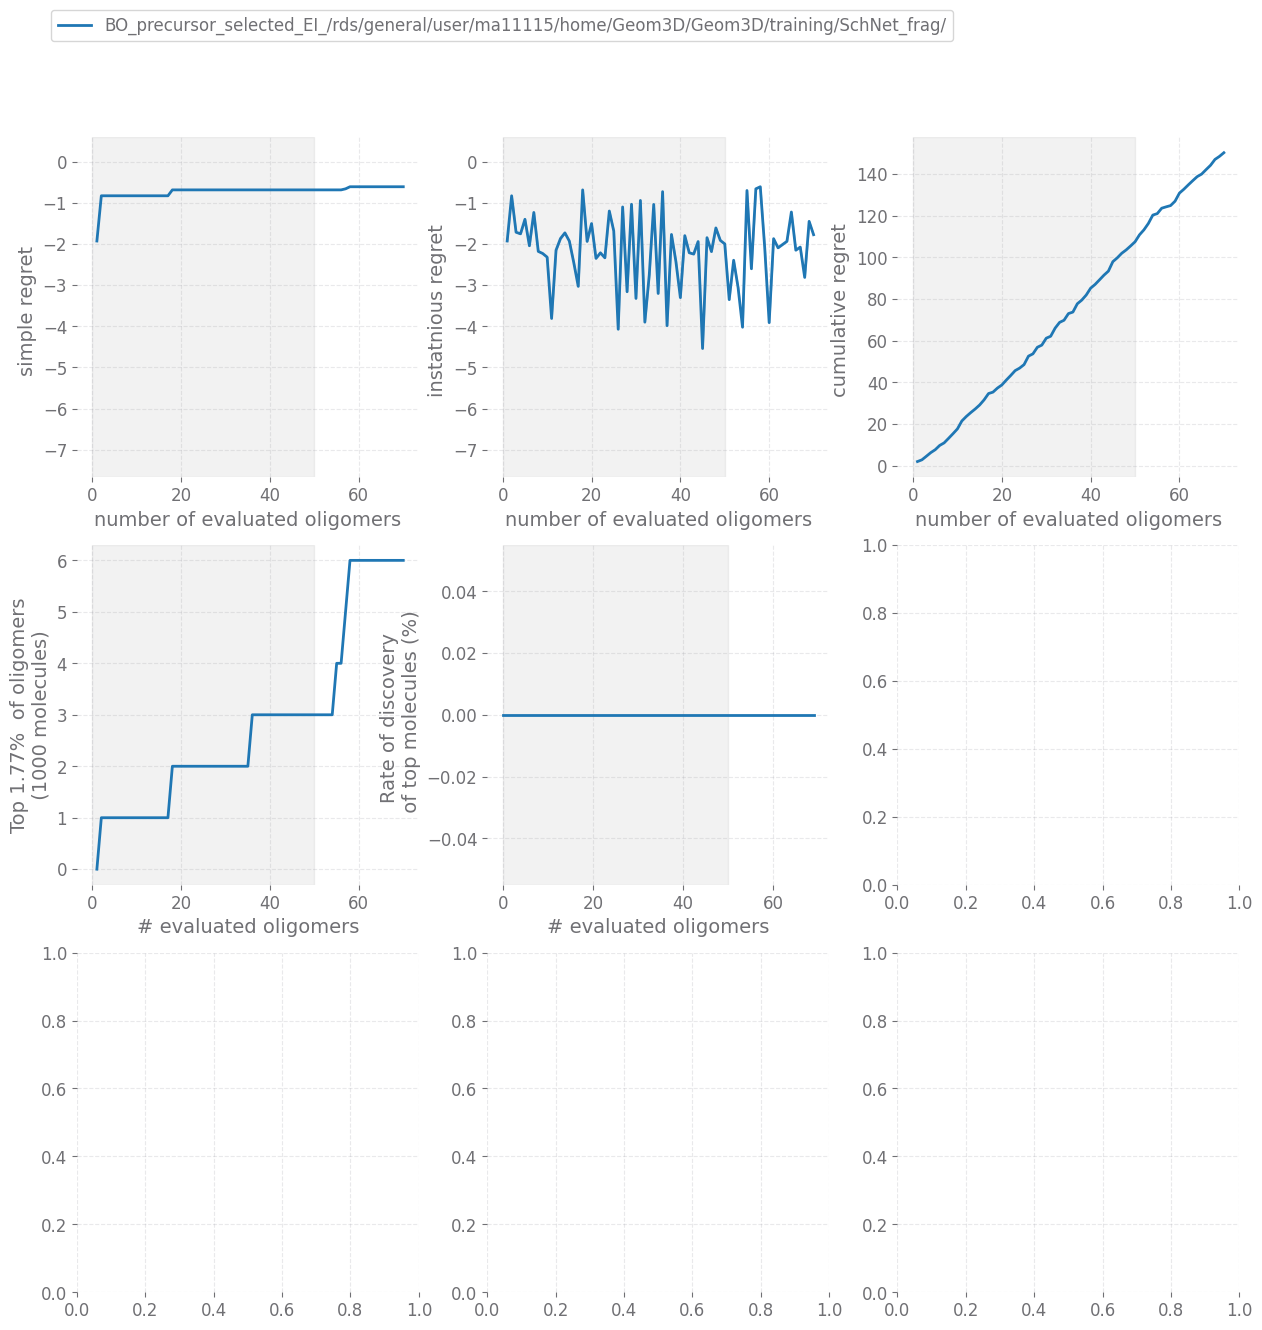

In [ ]:
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.iloc[[0]]
fig, axes,metric_dict_res = plot_results_all.plot_metric(df_plot,plot_function_list_single,results_dict,df_list,nb_iterations=70)

